# exp125
doppler加工

In [180]:
# import library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
from tqdm.notebook import tqdm
import pathlib
import plotly
import plotly.express as px
import itertools
import lightgbm as lgb
from optuna.integration import lightgbm as optuna_lgb
import simdkalman
import optuna
import pyproj
from pyproj import Proj, transform
from sklearn import metrics
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, accuracy_score
pd.set_option('display.max_rows', 100)

In [181]:
import ipynb_path

def get_nb_name():
    nb_path = ipynb_path.get()
    nb_name = nb_path.rsplit('/',1)[1].replace('.ipynb','')
    return nb_name

In [182]:
# directory setting
nb_name = get_nb_name()
INPUT = '../input/google-smartphone-decimeter-challenge'
OUTPUT = '../output/' + nb_name
os.makedirs(OUTPUT, exist_ok=True)

# utils

In [183]:
def get_train_score(df, gt):
    gt = gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
    df = df.merge(gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    # calc_distance_error
    df['err'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg'], df['lngDeg'])
    # calc_evaluate_score
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    res = df.groupby('phone')['err'].agg([percentile50, percentile95])
    res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2 
    score = res['p50_p90_mean'].mean()
    return score

In [184]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [185]:
def visualize_trafic(df, center, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()
    
def visualize_collection(df, collection):
    target_df = df[df['collectionName']==collection].copy()
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)

In [186]:
# ground_truth
def get_ground_truth():
    p = pathlib.Path(INPUT)
    gt_files = list(p.glob('train/*/*/ground_truth.csv'))

    gts = []
    for gt_file in gt_files:
        gts.append(pd.read_csv(gt_file))
    ground_truth = pd.concat(gts)

    return ground_truth

In [187]:
def percentile50(x):
    return np.percentile(x, 50)
def percentile95(x):
    return np.percentile(x, 95)

In [188]:
class train_result:
    def __init__(self, df):
        self.df = df
        self.gt = get_ground_truth()
        self.bl = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
        
        self.gt = self.gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
        self.df = self.df.merge(self.gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
        self.df['phone'] = self.df['collectionName'] + '_' + self.df['phoneName']
        self.df['err'] =  calc_haversine(self.df['latDeg_gt'], self.df['lngDeg_gt'], self.df['latDeg'], self.df['lngDeg'])
        
        self.phone_res = self.calc_err('phone')
        self.clc_res = self.calc_err('collectionName')
        self.phonename_res = self.calc_err('phoneName')
        
    def calc_err(self, by):
        res = self.df.groupby(by)['err'].agg([percentile50, percentile95])
        res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2
        return res
    
    @property
    def score(self):
        return self.phone_res['p50_p90_mean'].mean()
    @property
    def raw_data(self):
        return self.df
    @property
    def err(self):
        return self.phone_res
    @property
    def collection_err(self):
        return self.clc_res
    @property
    def phonename_err(self):
        return self.phonename_res
    
    def viz_map(self, collection, show_gt=True, show_bl=True):
        tmp = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp2 = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg_gt', 'lngDeg_gt']]
        tmp2 = tmp2.rename(columns={'latDeg_gt':'latDeg', 'lngDeg_gt':'lngDeg'})
        tmp2['phoneName'] = tmp2['phoneName'] + '_GT'
        tmp3 = self.bl[self.bl['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp3['phoneName'] = tmp3['phoneName'] + '_BL'
        
        if show_gt:
            tmp = tmp.append(tmp2)
        if show_bl:
            tmp = tmp.append(tmp3)
        visualize_collection(tmp, collection)

In [189]:
def get_data():
    base_train = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
    base_test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
    sample_sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')
    ground_truth = get_ground_truth()
    return base_train, base_test, sample_sub, ground_truth

In [190]:
train, test, sub, gt = get_data()
gt['phone'] = gt['collectionName'] + '_' + gt['phoneName']

In [191]:
dop_train = pd.read_csv('../output/prep/doppler_v001/result_train.csv')
dop_test = pd.read_csv('../output/prep/doppler_v001/result_test.csv')

In [192]:
dop_train = dop_train.sort_values(['phone', 'millisSinceGpsEpoch'])
dop_test = dop_test.sort_values(['phone', 'millisSinceGpsEpoch'])

In [193]:
dop_train['d'] = np.sqrt(dop_train['xVehVel']**2 + dop_train['yVehVel']**2 + dop_train['zVehVel']**2)
dop_test['d'] = np.sqrt(dop_test['xVehVel']**2 + dop_test['yVehVel']**2 + dop_test['zVehVel']**2)

In [194]:
dop_train_org = dop_train.copy()
dop_test_org = dop_test.copy()

# speed変化量が大きすぎるデータを除外

In [195]:
# gtでのspeed変化量を確認
gt['speed_diff'] = abs(gt['speedMps'] - gt.groupby('phone')['speedMps'].shift(1))

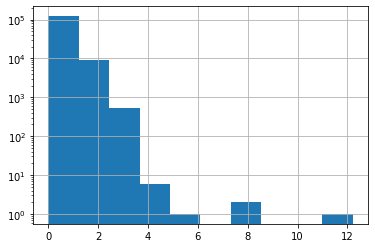

In [196]:
gt['speed_diff'].hist()
plt.yscale('log')

In [197]:
gt['speed_diff'].max()

12.21

In [198]:
gt[gt['speed_diff']>5]

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,timeSinceFirstFixSeconds,hDop,vDop,speedMps,courseDegree,phone,speed_diff
894,2021-01-05-US-SVL-1,Pixel5,1293917236437,37.378337,-122.067502,68.45,1114.44,0.0,0.0,16.69,0.61,2021-01-05-US-SVL-1_Pixel5,7.37
387,2021-01-05-US-SVL-2,Pixel4XL,1293919154436,37.378361,-122.067510,68.44,670.44,0.0,0.0,17.80,1.31,2021-01-05-US-SVL-2_Pixel4XL,8.00
742,2021-01-05-US-SVL-2,Pixel4XL,1293919511445,37.378357,-122.067510,68.44,1027.44,0.0,0.0,17.69,2.04,2021-01-05-US-SVL-2_Pixel4XL,5.15
2334,2020-09-04-US-SF-2,Pixel4,1283279934430,37.412012,-122.076601,43.42,2520.43,1.0,0.0,17.46,343.90,2020-09-04-US-SF-2_Pixel4,12.21


In [199]:
th=5

いったん5で

In [200]:
dop_train['d_diff_prev'] = abs(dop_train['d'] - dop_train.groupby('phone')['d'].shift(1))
dop_test['d_diff_prev'] = abs(dop_test['d'] - dop_test.groupby('phone')['d'].shift(1))
dop_train['d_diff_next'] = abs(dop_train['d'] - dop_train.groupby('phone')['d'].shift(-1))
dop_test['d_diff_next'] = abs(dop_test['d'] - dop_test.groupby('phone')['d'].shift(-1))

In [201]:
dop_train.loc[(dop_train['d_diff_prev']>th)&(dop_train['d_diff_next']>th), ['xVehVel', 'yVehVel', 'zVehVel', 'd']] = np.nan 
dop_test.loc[(dop_test['d_diff_prev']>th)&(dop_test['d_diff_next']>th), ['xVehVel', 'yVehVel', 'zVehVel', 'd']] = np.nan 

# speedが大きすぎるデータを除外

In [202]:
dop_train.loc[dop_train['d']>50, ['xVehVel', 'yVehVel', 'zVehVel', 'd']] = np.nan 
dop_test.loc[dop_test['d']>50, ['xVehVel', 'yVehVel', 'zVehVel', 'd']] = np.nan 

In [203]:
os.makedirs(f'{OUTPUT}/train/ro', exist_ok=True)

In [204]:
for phone in gt['phone'].unique():
    gt_tmp = gt[gt['phone']==phone].copy()
    dop_tmp = dop_train[dop_train['phone']==phone].copy()
    
    fig, axes = plt.subplots(figsize=(40, 15), nrows=3, sharex=True)
    axes[0].plot(gt_tmp['millisSinceGpsEpoch'], gt_tmp['speedMps'], label='speed')
    axes[0].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['d'], label='d')
    axes[0].legend(loc='upper right')
    axes[0].grid(color='g', linestyle=':', linewidth=0.3)
    
    axes[1].plot(gt_tmp['millisSinceGpsEpoch'], gt_tmp['courseDegree'], label='deg')
    axes[1].legend(loc='upper right')
    axes[1].grid(color='g', linestyle=':', linewidth=0.3)
    
    axes[2].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['xVehVel'], label='xVel')
    axes[2].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['yVehVel'], label='yVel')
    axes[2].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['zVehVel'], label='zVel')
    axes[2].legend(loc='upper right')
    axes[2].grid(color='g', linestyle=':', linewidth=0.3)
    fig.suptitle(phone, fontsize=16)
    fig.savefig(f'{OUTPUT}/train/ro/{phone}.png')
    plt.close()

In [205]:
os.makedirs(f'{OUTPUT}/test/ro', exist_ok=True)

In [206]:
for phone in dop_test['phone'].unique():
    dop_tmp = dop_test[dop_test['phone']==phone].copy()
    
    fig, axes = plt.subplots(figsize=(40, 10), nrows=2, sharex=True)
    axes[0].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['d'], label='d')
    axes[0].legend(loc='upper right')
    axes[0].grid(color='g', linestyle=':', linewidth=0.3)
        
    axes[1].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['xVehVel'], label='xVel')
    axes[1].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['yVehVel'], label='yVel')
    axes[1].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['zVehVel'], label='zVel')
    axes[1].legend(loc='upper right')
    axes[1].grid(color='g', linestyle=':', linewidth=0.3)
    fig.suptitle(phone, fontsize=16)
    fig.savefig(f'{OUTPUT}/test/ro/{phone}.png')
    plt.close()

# 移動平均

In [207]:
for s, c in itertools.product([3,5,10,15], ['xVehVel', 'yVehVel', 'zVehVel', 'd']):
    dop_train[f'{c}_rl{s}'] = dop_train.groupby('phone')[c].rolling(s, min_periods=1).mean().values
    dop_test[f'{c}_rl{s}'] = dop_test.groupby('phone')[c].rolling(s, min_periods=1).mean().values

In [208]:
os.makedirs(f'{OUTPUT}/train/rolling', exist_ok=True)

In [209]:
for phone in gt['phone'].unique():
    gt_tmp = gt[gt['phone']==phone].copy()
    dop_tmp = dop_train[dop_train['phone']==phone].copy()
    
    fig, axes = plt.subplots(figsize=(40, 20), nrows=4, sharex=True)
    axes[0].plot(gt_tmp['millisSinceGpsEpoch'], gt_tmp['speedMps'], label='speed')
    axes[0].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['d'], label='d')
    axes[0].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['d_rl3'], label='d_rl3')
    axes[0].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['d_rl5'], label='d_rl5')
    axes[0].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['d_rl10'], label='d_rl10')
    axes[0].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['d_rl15'], label='d_rl15')
    axes[0].legend(loc='upper right')
    axes[0].grid(color='g', linestyle=':', linewidth=0.3)
    
    axes[1].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['xVehVel'], label='xVel')
    axes[1].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['xVehVel_rl3'], label='xVel_rl3')
    axes[1].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['xVehVel_rl5'], label='xVel_rl5')
    axes[1].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['xVehVel_rl10'], label='xVel_rl10')
    axes[1].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['xVehVel_rl15'], label='xVel_rl15')
    axes[1].legend(loc='upper right')
    axes[1].grid(color='g', linestyle=':', linewidth=0.3)
    
    axes[2].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['yVehVel'], label='yVel')
    axes[2].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['yVehVel_rl3'], label='yVel_rl3')
    axes[2].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['yVehVel_rl5'], label='yVel_rl5')
    axes[2].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['yVehVel_rl10'], label='yVel_rl10')
    axes[2].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['yVehVel_rl15'], label='yVel_rl15')
    axes[2].legend(loc='upper right')
    axes[2].grid(color='g', linestyle=':', linewidth=0.3)
    
    axes[3].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['zVehVel'], label='zVel')
    axes[3].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['zVehVel_rl3'], label='zVel_rl3')
    axes[3].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['zVehVel_rl5'], label='zVel_rl5')
    axes[3].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['zVehVel_rl10'], label='zVel_rl10')
    axes[3].plot(dop_tmp['millisSinceGpsEpoch'], dop_tmp['zVehVel_rl15'], label='zVel_rl15')
    axes[3].legend(loc='upper right')
    axes[3].grid(color='g', linestyle=':', linewidth=0.3)
    
    fig.suptitle(phone, fontsize=16)
    fig.savefig(f'{OUTPUT}/train/rolling/{phone}.png')
    plt.close()